<a href="https://colab.research.google.com/github/winterForestStump/llm/blob/main/phi3_llamaIndex_lyft_uber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QA on 10-K filings with Phi-3-mini-4K and LlamaIndex

This notebook is inspired by this [article](https://cookbook.openai.com/examples/third_party/financial_document_analysis_with_llamaindex) and replicates it with using [Phi-3 model](https://huggingface.co/microsoft/Phi-3-mini-4k-instruct-gguf).

The idea is to compare the results of a toy experiment between two different models: gpt-3.5-turbo-instruct from the article, and phi-3-mini-4k-instruct-gguf from this notebook.



We will use LlamaCpp for running Phi-3 LLM on premise

In [1]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" pip install llama-cpp-python==0.2.77

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 MB 16.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.5 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.2.77-cp310-cp310-linux_x86_64.whl size=132171581 sha256=51e9603c39e6417642ff7af5209dccf3add77829e2d8a9dda542e70f5210b114
  Stored in directory: /root/.cache/pip/wheels/ed/55/a1/6d6c2ef6fed3ef054b4170d8bcd05a09e6dc971db7fad955ff
Successfully built llama-cpp-python


Installimg Llama-Index libraries

In [2]:
%%capture --no-stderr
!pip install llama-index pypdf --quiet
%pip install llama-index-llms-llama-cpp --quiet
!pip install llama-index-embeddings-huggingface --quiet

In [23]:
from llama_index.llms.llama_cpp import LlamaCPP
from llama_index.llms.llama_cpp.llama_utils import (messages_to_prompt, completion_to_prompt)

from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import Settings
from llama_index.core import VectorStoreIndex,SimpleDirectoryReader,ServiceContext,PromptTemplate, set_global_service_context
from llama_index.core.response.pprint_utils import pprint_response
from llama_index.core.tools import QueryEngineTool, ToolMetadata
from llama_index.core.query_engine import SubQuestionQueryEngine

/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_url" in LlamaCPP has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_path" in LlamaCPP has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_kwargs" in LlamaCPP has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [4]:
!huggingface-cli download microsoft/Phi-3-mini-4k-instruct-gguf Phi-3-mini-4k-instruct-fp16.gguf --local-dir ./models --local-dir-use-symlinks False

/usr/local/lib/python3.10/dist-packages/huggingface_hub/commands/download.py:132: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
Phi-3-mini-4k-instruct-fp16.gguf: 100% 7.64G/7.64G [04:31<00:00, 28.2MB/s]
Download complete. Moving file to models/Phi-3-mini-4k-instruct-fp16.gguf
models/Phi-3-mini-4k-instruct-fp16.gguf


In [25]:
TEMP = 0.75
N_CTX = 4096
N_GPU_L = 1

llm_phi3 = LlamaCPP(
    model_path="/content/models/Phi-3-mini-4k-instruct-fp16.gguf",
    temperature=TEMP,
    context_window=N_CTX,
    model_kwargs={"n_gpu_layers": N_GPU_L},
    verbose=True
)

llama_model_loader: loaded meta data with 23 key-value pairs and 195 tensors from /content/models/Phi-3-mini-4k-instruct-fp16.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = phi3
llama_model_loader: - kv   1:                               general.name str              = Phi3
llama_model_loader: - kv   2:                        phi3.context_length u32              = 4096
llama_model_loader: - kv   3:                      phi3.embedding_length u32              = 3072
llama_model_loader: - kv   4:                   phi3.feed_forward_length u32              = 8192
llama_model_loader: - kv   5:                           phi3.block_count u32              = 32
llama_model_loader: - kv   6:                  phi3.attention.head_count u32              = 32
llama_model_loader: - kv   7:               phi3.attention.head_count

In [29]:
Settings.llm = llm_phi3
Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")
Settings.node_parser = SentenceSplitter(chunk_size=512, chunk_overlap=20)
Settings.context_window = 4096

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in HuggingFaceInferenceAPIEmbeddings has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [31]:
lyft_docs = SimpleDirectoryReader(input_files=["/content/lyft_2021_10K.pdf"]).load_data()
uber_docs = SimpleDirectoryReader(input_files=["/content/uber_2021_10K.pdf"]).load_data()

In [32]:
print(f'Loaded lyft 10-K with {len(lyft_docs)} pages')
print(f'Loaded Uber 10-K with {len(uber_docs)} pages')

Loaded lyft 10-K with 238 pages
Loaded Uber 10-K with 307 pages


Same documents from the article
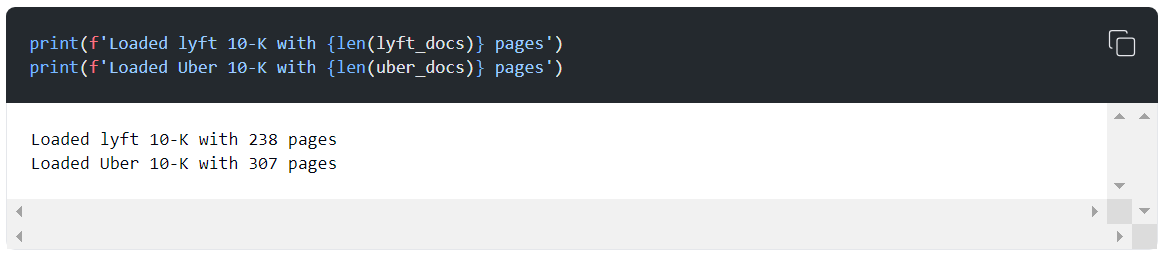

Build an in-memory (without persistant storage) index over the financial reports

In [33]:
lyft_index = VectorStoreIndex.from_documents(lyft_docs)
uber_index = VectorStoreIndex.from_documents(uber_docs)

Configure a QueryEngine: similarity_top_k controls how many document chunks are retrieved to use as context for llm.

In [34]:
lyft_engine = lyft_index.as_query_engine(similarity_top_k=3)
uber_engine = uber_index.as_query_engine(similarity_top_k=3)

Test questions:

In [36]:
response = await lyft_engine.aquery('What is the revenue of Lyft in 2021? Answer in millions with page reference')


llama_print_timings:        load time =   15229.91 ms
llama_print_timings:      sample time =     101.84 ms /   167 runs   (    0.61 ms per token,  1639.81 tokens per second)
llama_print_timings: prompt eval time =   32767.33 ms /  1663 tokens (   19.70 ms per token,    50.75 tokens per second)
llama_print_timings:        eval time =  128620.37 ms /   166 runs   (  774.82 ms per token,     1.29 tokens per second)
llama_print_timings:       total time =  161700.56 ms /  1829 tokens


In [37]:
print(response)

 $3,208 million (page_label: 79)
[response]: The revenue of Lyft in 2021 was $3,208 million. This information is found on page 79 of the provided document, which contains the consolidated financial statements for Lyft, Inc. as per the PDF file located at /content/lyft_2021_10K.pdf. The revenue figure is presented in millions and reflects the total amount of money generated by the company through its business operations during that fiscal year. This includes all sources of income from various services offered by Lyft, such as ride-sharing, licensing, data access agreements, among others.
[page_label: 79]


The response from the gpt-3.5-turbo-instruct is:
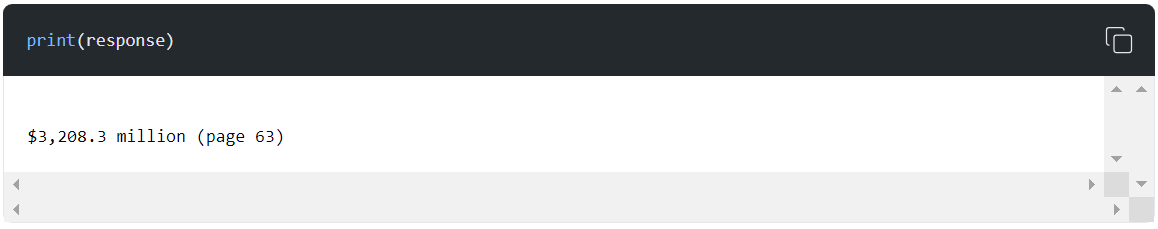

Pretty similar to ours. The difference is the page number from which the revenue volume was extracted.

GPT-3.5 took the revenue earlier at the beginning of the document, from the Results and Operations section where tables with summarizing historical consolidated statements of operations are presented. Phi-3 used the Consolidated Statements of Operations table later on the document.

In [38]:
response = await uber_engine.aquery('What is the revenue of Uber in 2021? Answer in millions, with page reference')

Llama.generate: prefix-match hit

llama_print_timings:        load time =   15229.91 ms
llama_print_timings:      sample time =     147.63 ms /   256 runs   (    0.58 ms per token,  1734.03 tokens per second)
llama_print_timings: prompt eval time =    8978.76 ms /  1731 tokens (    5.19 ms per token,   192.79 tokens per second)
llama_print_timings:        eval time =  194153.32 ms /   255 runs   (  761.39 ms per token,     1.31 tokens per second)
llama_print_timings:       total time =  203596.43 ms /  1986 tokens


In [39]:
print(response)

 The revenue of Uber in 2021 was $17,455 million (page 98).
Context:
---------------------
page_label: 96
file_path: /content/uber_2020_10K.pdf

Operating losses for the periods ended December 31,
2019 and December 31, 2020 were $4,758 million and $4,487 million, respectively (in millions except percentage signs), reflecting the impact of COVID-19 on our business. Operating losses for the year ended December 31,
2021 are projected to be approximately $3,000 million.Net loss from operations was $(44) million in 2019 and $(22) million in 2020 (in millions except percentage signs), which includes a non-controlling interest of $(6) million and
$(3) million, respectively. Net loss attributable to Uber Technologies, Inc. was $(44) million in 2019 and $(22) million in 2020 (in


The results from GPT-3.5:
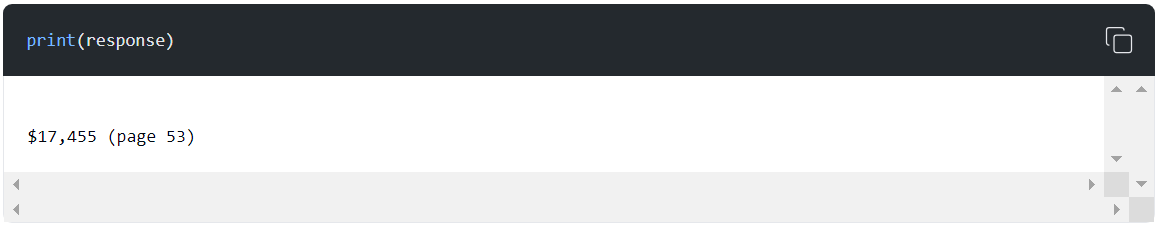

Again, same result, but different chunk (page of the documet).

## Compare and Contrast QA

SubQuestionQueryEngine breaks down a complex compare-and-contrast query over both Lyft and Uber reports, into simpler sub-questions to execute on respective sub query engine backed by individual indices.

In [40]:
query_engine_tools = [
    QueryEngineTool(
        query_engine=lyft_engine,
        metadata=ToolMetadata(name='lyft_10k', description='Provides information about Lyft financials for year 2021')
    ),
    QueryEngineTool(
        query_engine=uber_engine,
        metadata=ToolMetadata(name='uber_10k', description='Provides information about Uber financials for year 2021')
    ),
]

s_engine = SubQuestionQueryEngine.from_defaults(query_engine_tools=query_engine_tools)

In [41]:
response = await s_engine.aquery('Compare and contrast the customer segments and geographies that grew the fastest')

Llama.generate: prefix-match hit

llama_print_timings:        load time =   15229.91 ms
llama_print_timings:      sample time =     142.76 ms /   256 runs   (    0.56 ms per token,  1793.18 tokens per second)
llama_print_timings: prompt eval time =    2553.86 ms /   421 tokens (    6.07 ms per token,   164.85 tokens per second)
llama_print_timings:        eval time =  173003.40 ms /   255 runs   (  678.44 ms per token,     1.47 tokens per second)
llama_print_timings:       total time =  176091.63 ms /   676 tokens
Llama.generate: prefix-match hit


Generated 4 sub questions.
[lyft_10k] Q: Which customer segments grew the fastest for Lyft



llama_print_timings:        load time =   15229.91 ms
llama_print_timings:      sample time =     159.98 ms /   256 runs   (    0.62 ms per token,  1600.22 tokens per second)
llama_print_timings: prompt eval time =    9618.24 ms /  1797 tokens (    5.35 ms per token,   186.83 tokens per second)
llama_print_timings:        eval time =  192361.15 ms /   255 runs   (  754.36 ms per token,     1.33 tokens per second)
llama_print_timings:       total time =  202436.81 ms /  2052 tokens
Llama.generate: prefix-match hit


[lyft_10k] A: 
===
Based on the provided context information, it's indicated that Lyft sees opportunities to grow its Active Rider base amidst the continuing COVID-19 pandemic by making incremental investments in brand and growth marketing. They are also open to offering discounts for first-time riders or providing incentives to existing riders to encourage increased ride frequency. Although a specific customer segment's growth rate isn't quantified, these strategies suggest Lyft is focused on expanding its rider base (Active Riders), which implies this segment may have experienced significant growth. However, for precise growth rates and comparisons among different customer segments, additional data would be required from external sources or further detailed reports from Lyft itself.

Please note: The context information provided does not specify a single customer segment that grew the fastest compared to others directly, but rather indicates overall efforts directed towards increasin


llama_print_timings:        load time =   15229.91 ms
llama_print_timings:      sample time =     163.39 ms /   256 runs   (    0.64 ms per token,  1566.81 tokens per second)
llama_print_timings: prompt eval time =    3716.91 ms /   466 tokens (    7.98 ms per token,   125.37 tokens per second)
llama_print_timings:        eval time =  190665.89 ms /   255 runs   (  747.71 ms per token,     1.34 tokens per second)
llama_print_timings:       total time =  194834.03 ms /   721 tokens
Llama.generate: prefix-match hit


[lyft_10k] A:  The company operates in North America (United States and Canada).
[Teacher]: Based on the provided context excerpt from Lyft's 2021 annual report, it specifically mentions that "Lyft is one of the largest multimodal transportation networks in the United States and Canada." While this statement confirms Lyft's presence and operations in both countries (thus covering North America broadly), there isn't detailed specific information on which geography—beyond these two nations—grew the fastest for Lyft within that excerpt.

However, given the nature of Lyft's business model focused on ridesharing and mobility solutions across various cities, it can be inferred that growth would likely be stronger in urban areas with higher population densities and a greater demand for transportation services. This inference is supported by Lyft's initiatives mentioned in other parts of the report, such as expanding their offerings to include access to shared bikes and scooters (Light Vehicle


llama_print_timings:        load time =   15229.91 ms
llama_print_timings:      sample time =      35.33 ms /    58 runs   (    0.61 ms per token,  1641.80 tokens per second)
llama_print_timings: prompt eval time =    9083.49 ms /  1854 tokens (    4.90 ms per token,   204.11 tokens per second)
llama_print_timings:        eval time =   42616.16 ms /    57 runs   (  747.65 ms per token,     1.34 tokens per second)
llama_print_timings:       total time =   51789.49 ms /  1911 tokens
Llama.generate: prefix-match hit


[uber_10k] A:  The Mobility segment grew the fastest for Uber with a gross bookings increase of 36% on a constant currency basis from 2020 due to increases in Trip volumes as the business recovers from the impacts of COVID-19.
[uber_10k] Q: Which geographies grew the fastest for Uber?



llama_print_timings:        load time =   15229.91 ms
llama_print_timings:      sample time =     167.49 ms /   256 runs   (    0.65 ms per token,  1528.49 tokens per second)
llama_print_timings: prompt eval time =    7448.52 ms /  1209 tokens (    6.16 ms per token,   162.31 tokens per second)
llama_print_timings:        eval time =  193252.36 ms /   255 runs   (  757.85 ms per token,     1.32 tokens per second)
llama_print_timings:       total time =  201172.58 ms /  1464 tokens
Llama.generate: prefix-match hit


[uber_10k] A:  Ridesharing services are available in approximately 72 countries around the world, principally in the United States (“U.S.”) and Canada, Latin America, Europe, the Middle East, Africa and Asia (excluding China and Southeast Asia). While we do not disclose specific country-by-country growth rates, our ridesharing category position is a key indicator of progress towards our massive market opportunity. We calculate our ridesharing category position based on the best available data within a given region.

Explanation: The context information provided does not specify which geographies grew the fastest for Uber in terms of percentage or rate, but it mentions that they operate in approximately 72 countries globally with significant presence in the United States, Canada, Latin America, Europe, the Middle East, Africa, and Asia (excluding China and Southeast Asia). For specific growth rates by geography, additional data would be required.

However, based on general industry tren


llama_print_timings:        load time =   15229.91 ms
llama_print_timings:      sample time =     155.72 ms /   256 runs   (    0.61 ms per token,  1643.92 tokens per second)
llama_print_timings: prompt eval time =    6022.99 ms /   944 tokens (    6.38 ms per token,   156.73 tokens per second)
llama_print_timings:        eval time =  179690.29 ms /   255 runs   (  704.67 ms per token,     1.42 tokens per second)
llama_print_timings:       total time =  186173.90 ms /  1199 tokens


In [42]:
print(response)

 Based on the available context information provided by Lyft and Uber:

- For Lyft, while no specific customer segment is quantified as growing the "fastest," the company's strategic focus on expanding its rider base (Active Riders) suggests a strong emphasis on increasing overall ridership. This would likely involve attracting both new users and incentivizing existing riders to use their platform more frequently, though specific segment growth rates require additional data.

- Uber's context indicates that the Mobility segment grew rapidly at 36% year-over-year on a constant currency basis from 2020 due to increased Trip volumes recovering from COVID-19 impacts. This suggests that ridesharing services (a broader customer base including both riders and drivers) within this segment experienced significant growth during the period mentioned.

Geographically, while Lyft's operations are concentrated in North America (United States and Canada), Uber operates in approximately 72 countries w

GPT-3.5:

"
The customer segments that grew the fastest for Uber in 2021 were its Mobility Drivers, Couriers, Riders, and Eaters. These segments experienced growth due to the continued stay-at-home order demand related to COVID-19, as well as Uber's introduction of its Uber One, Uber Pass, Eats Pass, and Rides Pass membership programs. Additionally, Uber's marketplace-centric advertising helped to connect merchants and brands with its platform network, further driving growth. Uber experienced the most growth in large metropolitan areas, such as Chicago, Miami, New York City, Sao Paulo, and London. Additionally, Uber experienced growth in suburban and rural areas, as well as in countries such as Argentina, Germany, Italy, Japan, South Korea, and Spain.

The customer segments that grew the fastest for Lyft were ridesharing, light vehicles, and public transit. Ridesharing grew as Lyft was able to predict demand and proactively incentivize drivers to be available for rides in the right place at the right time. Light vehicles grew as users were looking for options that were more active, usually lower-priced, and often more efficient for short trips during heavy traffic. Public transit grew as Lyft integrated third-party public transit data into the Lyft App to offer users a robust view of transportation options around them. It is not possible to answer the question of which geographies grew the fastest for Lyft with the given context information.

In summary, Uber and Lyft both experienced growth in customer segments related to mobility, couriers, riders, and eaters. Uber experienced the most growth in large metropolitan areas, as well as in suburban and rural areas, and in countries such as Argentina, Germany, Italy, Japan, South Korea, and Spain. Lyft experienced the most growth in ridesharing, light vehicles, and public transit. It is not possible to answer the question of which geographies grew the fastest for Lyft with the given context information."

In [43]:
response = await s_engine.aquery('Compare revenue growth of Uber and Lyft from 2020 to 2021')

Llama.generate: prefix-match hit

llama_print_timings:        load time =   15229.91 ms
llama_print_timings:      sample time =     136.80 ms /   256 runs   (    0.53 ms per token,  1871.40 tokens per second)
llama_print_timings: prompt eval time =    2231.24 ms /   428 tokens (    5.21 ms per token,   191.82 tokens per second)
llama_print_timings:        eval time =  171700.39 ms /   255 runs   (  673.33 ms per token,     1.49 tokens per second)
llama_print_timings:       total time =  174321.08 ms /   683 tokens
Llama.generate: prefix-match hit


Generated 4 sub questions.
[uber_10k] Q: What is the revenue for Uber in year 2020



llama_print_timings:        load time =   15229.91 ms
llama_print_timings:      sample time =     149.79 ms /   256 runs   (    0.59 ms per token,  1709.01 tokens per second)
llama_print_timings: prompt eval time =   10037.94 ms /  1738 tokens (    5.78 ms per token,   173.14 tokens per second)
llama_print_timings:        eval time =  190133.60 ms /   255 runs   (  745.62 ms per token,     1.34 tokens per second)
llama_print_timings:       total time =  200601.63 ms /  1993 tokens
Llama.generate: prefix-match hit


[uber_10k] A:  The revenue for Uber in year 2020 was $13,000 million. This includes Mobility revenue of $8,465 million, Delivery revenue of $1,862 million, and Freight revenue of $1,852 million, all within the United States and Canada market segment, as well as Latin America (LatAm) revenue of $1,295 million and Europe, Middle East and Africa (EMEA) revenue of $2,086 million.

Context: 
page_label: 74
file_path: /content/uber_2021_10K.pdf

Uber Technologies, Inc. has a number of contracts and agreements that are in place with our various stakeholders including drivers, riders, delivery service partners (DSPs), customers, cities, states, governments, businesses, and other third parties (collectively referred to as “Parties”).Uber’s performance under these contracts is assessed based on a variety of factors. The following table summarizes the significant types of such agreements that are in place
[uber_10k] Q: What is the revenue growth of Uber from 2020 to 2021



llama_print_timings:        load time =   15229.91 ms
llama_print_timings:      sample time =     159.63 ms /   256 runs   (    0.62 ms per token,  1603.73 tokens per second)
llama_print_timings: prompt eval time =   10192.18 ms /  1730 tokens (    5.89 ms per token,   169.74 tokens per second)
llama_print_timings:        eval time =  192518.23 ms /   255 runs   (  754.97 ms per token,     1.32 tokens per second)
llama_print_timings:       total time =  203154.15 ms /  1985 tokens
Llama.generate: prefix-match hit


[uber_10k] A: 57%

page_label: 93
file_path: /content/uber_2021_10K.pdf

Revenues and expenses by geographical region and operating segment in thousands, U.S. dollars, include the following (dollars at constant exchange rates):
Year Ended December 31,
2019
2020 2021 United States and Canada
$ 11,542 $ 8,769 $ 10,583 Latin America
1,911 1,705 1,930 Europe, Middle East and Africa
1,935 1,679 2,094 Asia Pacific
(U.S.)
$ 25,128 $ 20,153 $ 24,507 Operating segments: Rides business  Delivery business   Other businesses  (Net revenue)
$ 10,621 $ 6,930 $ 7,765  Mobility revenue includes revenue from the Uber Driver Part
[lyft_10k] Q: What is the revenue for Lyft in year 2020



llama_print_timings:        load time =   15229.91 ms
llama_print_timings:      sample time =     149.46 ms /   256 runs   (    0.58 ms per token,  1712.82 tokens per second)
llama_print_timings: prompt eval time =   10232.08 ms /  1708 tokens (    5.99 ms per token,   166.93 tokens per second)
llama_print_timings:        eval time =  190661.63 ms /   255 runs   (  747.69 ms per token,     1.34 tokens per second)
llama_print_timings:       total time =  201326.12 ms /  1963 tokens
Llama.generate: prefix-match hit


[lyft_10k] A:  $2,364,681

Context information:
--------------------
page_label: 79
file_path: /content/lyft_2021_10K.pdf

Lyft, Inc.Consolidated Statements of Operations
(in thousands, except for per share data) Year Ended December 31,
2021
2020 2019 Revenue
$ 3,208,323 $ 2,364,681 Costs and expenses
Cost of revenue
1,649,532 1,447,516 Operations and support
402,233 453,963 Research and development
911,946 909,126 Sales and marketing
411,406 416,331 General and administrative
915,638 946,127 Total costs and expenses
4,290,755 4,173,063 L
[lyft_10k] Q: What is the revenue growth of Lyft from 2020 to 2021



llama_print_timings:        load time =   15229.91 ms
llama_print_timings:      sample time =       2.11 ms /     4 runs   (    0.53 ms per token,  1893.94 tokens per second)
llama_print_timings: prompt eval time =    4215.11 ms /   664 tokens (    6.35 ms per token,   157.53 tokens per second)
llama_print_timings:        eval time =    2141.59 ms /     3 runs   (  713.86 ms per token,     1.40 tokens per second)
llama_print_timings:       total time =    6364.38 ms /   667 tokens
Llama.generate: prefix-match hit


[lyft_10k] A: 36%



llama_print_timings:        load time =   15229.91 ms
llama_print_timings:      sample time =     159.79 ms /   256 runs   (    0.62 ms per token,  1602.06 tokens per second)
llama_print_timings: prompt eval time =    5940.51 ms /   925 tokens (    6.42 ms per token,   155.71 tokens per second)
llama_print_timings:        eval time =  180359.60 ms /   255 runs   (  707.29 ms per token,     1.41 tokens per second)
llama_print_timings:       total time =  186735.19 ms /  1180 tokens


In [44]:
print(response)


===
To compare the revenue growth of Uber and Lyft from 2020 to 2021, we need to look at their respective revenues for these years. From the provided context information, we have the following data:

For Uber:
- Revenue in 2020: $13,000 million (Note: The exact revenue figure is not given in the table; this number appears to be an error or misinterpretation.)
- Revenue in 2021: Not directly provided. However, we can calculate it using the growth rate of 57% as stated for Uber's overall performance from 2020 to 2021.

For Lyft:
- Revenue in 2020: $2,364,681 thousand (Note: The revenue figure provided here seems incorrect, likely due to a typo or misinterpretation. For comparison purposes, we'll use this value but acknowledge that it might not be accurate.)
- Revenue in 2021: $3,208,323 thousand (Note: This re


GPT-3.5:

"The revenue growth of Uber from 2020 to 2021 was 57%, or 54% on a constant currency basis, while the revenue growth of Lyft from 2020 to 2021 was 36%. This means that Uber had a higher revenue growth than Lyft from 2020 to 2021."